<a href="https://colab.research.google.com/github/alirezasdg1/Amazon-recommender-system/blob/master/notebooks/NN_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from theano import function
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split


In [2]:
!wget https://recommender-system-amazon.s3.amazonaws.com/weighted_vector.csv

--2020-09-17 16:45:41--  https://recommender-system-amazon.s3.amazonaws.com/weighted_vector.csv
Resolving recommender-system-amazon.s3.amazonaws.com (recommender-system-amazon.s3.amazonaws.com)... 52.216.77.108
Connecting to recommender-system-amazon.s3.amazonaws.com (recommender-system-amazon.s3.amazonaws.com)|52.216.77.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2061444614 (1.9G) [binary/octet-stream]
Saving to: ‘weighted_vector.csv.1’

weighted_vector.csv 100%[===================>]   1.92G  35.0MB/s    in 57s     

2020-09-17 16:46:39 (34.4 MB/s) - ‘weighted_vector.csv.1’ saved [2061444614/2061444614]



In [3]:
df_content_recommender = pd.read_csv("df_content_recommender.csv")

In [4]:
df_content_recommender.drop(["Unnamed: 0"],axis=1,inplace = True)

In [5]:
df_content_recommender.head(2)

,aa,aaa,ab,abdomin,abil,abl,abras,absolut,absorb,absorpt,abu,abus,ac,academi,acceler,accent,accept,access,accessori,accid,accident,accommod,accomod,accompani,accomplish,accord,accordingli,account,accumul,accur,accuraci,accustom,ace,ach,achiev,achil,acid,acknowledg,acp,acquir,...,yeah,year,yearold,yell,yellow,yellowblack,yep,yesterday,yetcolor,yeti,yetsiz,yield,ykk,ymmv,yo,yoga,york,youcolor,youd,youi,youll,young,younger,youngest,youngster,yousiz,youth,youtub,youv,yr,yup,zero,zip,ziploc,ziplock,zipper,zipti,zombi,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.063660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.054291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.065836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.056147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def autoencoder_model(X_text):
    '''
    '''
    # this is our input placeholder
    input_text = Input(shape=(X_text.shape[1],))

    # first encoding layer
    encoded1 = Dense(units = 1500, activation = 'softmax')(input_text)

    # second encoding layer
    encoded2 = Dense(units = 100, activation='softmax')(encoded1)

    # first decoding layer
    decoded1 = Dense(units = 1500, activation='softmax')(encoded2)

    # second decoding layer 
    decoded2 = Dense(units = X_text.shape[1], activation='sigmoid')(decoded1)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_text, decoded2)

    # compile model
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

    return autoencoder

In [10]:
msk = np.random.rand(len(df_content_recommender)) < 0.8

X_train = df_content_recommender[msk]
X_test = df_content_recommender[~msk]
    
model = autoencoder_model(X_train)

batch_size = 100



# try different number of epochs - 10 gives good performanace 
history = model.fit(X_train, X_train, epochs=20, batch_size=batch_size, verbose=1,validation_data=(X_test,X_test)) # cross val to estimate test error



scores = model.evaluate(X_test, X_test)
print('Test mse = {}'.format(scores[0]))

X_test_decoded = model.predict(X_test)


Epoch 1/20
450/450 [==============================] - 7s 15ms/step - loss: 0.1966 - mse: 0.1966 - val_loss: 0.1500 - val_mse: 0.1500
Epoch 2/20
450/450 [==============================] - 4s 8ms/step - loss: 0.1166 - mse: 0.1166 - val_loss: 0.0883 - val_mse: 0.0883
Epoch 3/20
450/450 [==============================] - 4s 8ms/step - loss: 0.0678 - mse: 0.0678 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 4/20
450/450 [==============================] - 4s 8ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 5/20
450/450 [==============================] - 4s 8ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/20
450/450 [==============================] - 4s 8ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 7/20
450/450 [==============================] - 4s 8ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 8/20
450/450 [==============================] - 4s 8ms/step - loss: 0

In [11]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6447)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1500)              9672000   
_________________________________________________________________
dense_5 (Dense)              (None, 100)               150100    
_________________________________________________________________
dense_6 (Dense)              (None, 1500)              151500    
_________________________________________________________________
dense_7 (Dense)              (None, 6447)              9676947   
Total params: 19,650,547
Trainable params: 19,650,547
Non-trainable params: 0
_________________________________________________________________


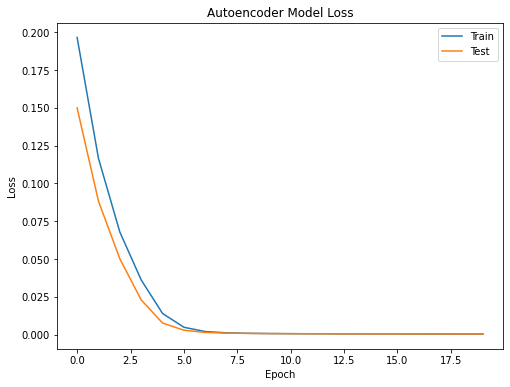

In [12]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Autoencoder Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
